# Use jobs for a smoothless experience with pulse sequence sweeps.
One of the main reason to use pulse-level control is to characterize a quantum system at the lowest level. Extracting this experimental information will allow for building an device Hamiltonian model that could be then compared with results obtained from the real device.

Often, protocols to obtain these experimental data consist in varying a control parameter and record the response of the system. This was for instance the case in the first example notebook. Here we will give a different color to this notebook by leverage jobs that will encapsulate a sweep in a single job instance, allowing to group all the task results together and benefit from the queue priority. 

You can use either Rigetti's Aspen M-3 or OQC's Lucy device to run this notebook.

In [1]:
# Use Braket SDK Cost Tracking to estimate the cost to run this example
from braket.tracking import Tracker
t = Tracker().start()

Let's first import some packages to construct pulse sequences and analyze results.

In [2]:
%matplotlib inline

## Imports for function fitting
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
# from scipy.fft import fft, fftfreq

You will be able to switch from one device to the other by using the corresponding `arn`.

## Qubit spectropscopy

Qubit spectroscopy is one of the first step to charaterize a qubit. While this information is already present in the frame properties, we will build a pulse sequence to estimate the transition frequency between the ground state and the first excited state.

For simplicity, we will use Gaussian or Constant waveforms as envelopes of the different pulses. The Gaussian waveforms are parametrized by their amplitude $A$ and the length $d$ of their pulse window. They are positioned at the center of the window ($d$/2) and their width (1/e) will be set to be a quarter of the window length ($d$/4). The Constant waveforms have a complex amplitude $iq$ . 

For qubit spectroscopy, while a prior knowledge of the systems helps choosing these parameters to increase the signal-to-noise ratio, it is not necessary to tune them precisely. 

With Aspen, we will use a pulse length of 100ns, the Gaussian has a width of 25ns and its amplitude is 0.1. With Lucy, We will use a pulse length of 25ns and an amplitude is 0.03. The amplitude unit should be considered as arbitrary, the maximum amplitude can be retrieved from the device capabilities, please see the documentation for more details.

In [3]:
hyperparameters = {"N_shots": 100, "N_steps": 25, "qubit": 4}

In [10]:
from braket.aws import AwsQuantumJob

job = AwsQuantumJob.create(
    device="arn:aws:braket:us-west-1::device/qpu/rigetti/Aspen-M-3",
    source_module="qubit_spectroscopy/qubit_spectroscopy_sweep.py",
    hyperparameters=hyperparameters,
    wait_until_complete=True,
)

Initializing Braket Job: arn:aws:braket:us-west-1:824069584567:job/braket-job-default-1685553660914
......................
2023-05-31 17:22:58,792 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-05-31 17:22:58,806 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-05-31 17:22:58,818 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-05-31 17:22:58,828 sagemaker-training-toolkit INFO     Invoking user script
Training Env:
{
    "additional_framework_parameters": {},
    "channel_input_dirs": {},
    "current_host": "algo-1",
    "framework_module": null,
    "hosts": [
        "algo-1"
    ],
    "hyperparameters": {
        "N_shots": 100,
        "N_steps": 25,
        "qubit": 4
    },
    "input_config_dir": "/opt/ml/input/config",
    "input_data_config": {},
    "input_dir": "/opt/ml/input",
    "is_master": true,
    "job_name": "130c0429-4689-4bfb-8201-a4ca22d71c28",

You can now retrieve the collection of tasks associated with your Qubit spectroscopy sweep. If you don't have access to the job object created with `AwsQuantumJob.create`, you could always recreate it from the job arn `job_arn` that you can copy from the [Braket console](https://console.aws.amazon.com/braket/) (use the region corresponding to the device that you used):

In [11]:
job.state()

'COMPLETED'

In [13]:
# job = AwsQuantumJob(job_arn)

You can now retrieve all the tasks...

After executing the job, we are ready to analyze the results. We will use a simple Gaussian fit function to extract the transition frequency.

In [14]:
def resonance_fit(x, A, A0, w, x0):
    return A0-A*np.exp(-(x-x0)**2/w**2)

The result format is the same as with circuits, which means that `result()` will return a task result object that includes a counter with the number of occurences for each eigenstate of the measurement basis. Since we have been using a batch, we can quickly construct the probability to measure the state $|0\rangle$. 

The data are then plotted and fitted with the previously defined fit function.

In [15]:
results = job.result()  # will return once job.state() = "COMPLETED", should be 4 minutes
print("populations in |0>: ", results["populations in |0>"])
print("frequencies: ", results["frequencies"])

populations in |0>:  [1.0, 1.0, 1.0, 1.0, 1.0, 0.99, 1.0, 0.99, 0.97, 0.79, 0.58, 0.34, 0.22, 0.18, 0.57, 0.85, 0.96, 0.98, 0.99, 0.98, 1.0, 0.98, 1.0, 1.0, 0.99]
frequencies:  [5162128523.00516, 5165253523.00516, 5168378523.00516, 5171503523.00516, 5174628523.00516, 5177753523.00516, 5180878523.00516, 5184003523.00516, 5187128523.00516, 5190253523.00516, 5193378523.00516, 5196503523.00516, 5199628523.00516, 5202753523.00516, 5205878523.00516, 5209003523.00516, 5212128523.00516, 5215253523.00516, 5218378523.00516, 5221503523.00516, 5224628523.00516, 5227753523.00516, 5230878523.00516, 5234003523.00516, 5237128523.00516]


Measured resonance frequency: 5199.9 GHz


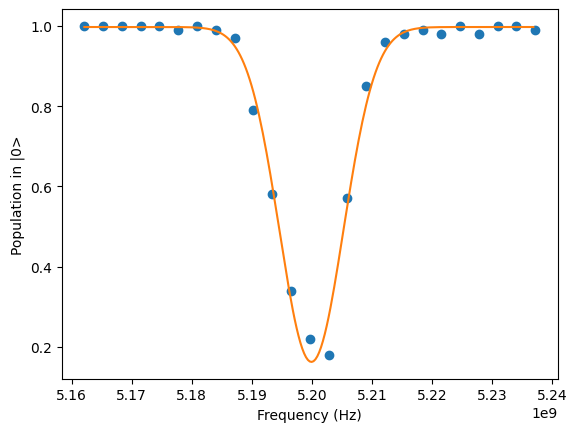

In [16]:
x, y = results["frequencies"], results["populations in |0>"]

initial_guess=[1/2, 1, 10e6, (x[-1]+x[0])/2] # Amplitude, Offset, width, centerFrequency
optimal_params, _ = scipy.optimize.curve_fit(resonance_fit, x, y, p0=initial_guess)
x_fit = np.arange(x[0],x[-1], np.diff(x)[0]/10)
y_fit = resonance_fit(x_fit, *optimal_params)

plt.figure()
plt.plot(x,y, 'o')
plt.plot(x_fit,y_fit)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Population in |0>")

resonance_frequency = optimal_params[3]
print('Measured resonance frequency:', round(resonance_frequency*1e-6,2), 'GHz')

In [17]:
print("Task Summary")
print(job.result()['task summary'])
print('Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).')
print(f"Estimated cost to run tasks in this job: {job.result()['estimated cost']} USD")

Task Summary
{'arn:aws:braket:us-west-1::device/qpu/rigetti/Aspen-M-3': {'shots': 2500, 'tasks': {'COMPLETED': 25}}}
Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).
Estimated cost to run tasks in this job: 8.375 USD
